# Second Example of factorizing quantum linear systems with time-delayed feedback

The purpose of this notebook is to apply our method to the system explored in https://arxiv.org/abs/1606.00178

Unlike our other example, this system exhibits interesitng squeezing behavior that depends on the time delays.

To set up this system, we begin with a squeezing system having two input and two output ports in parallel with a beamsplitter (also having two input and output ports). At this point the system has a total of four ports, or eight input-output channels in the doubled-up picture where the creation and annihilation fields are considered separately.

The system is initially set up with inputs $(b_{in}(t), c_{in}(t), \xi(t), c_{out}(t-\tau) e ^{i \phi})$ and outputs $(b_{out}(t), c_{out}(t), loss, b_{in}(t))$, where the notation is the same as the cited paper. We then use the permutation matrices $P_{in}$ and $P_{out}$ to exchange the ports so they are conveniently ordered. The new input ports are $(c_{in}(t), \xi(t), b_{in}(t), c_{out}(t-\tau)e^{i \phi}))$, and the new output ports are $(b_{out}(t), loss, b_{in}(t), c_{out}(t))$. The channels are also permutted to go from the doubled-up convention where annihilation ports come first and then all creation ports, to the convention where the annihilation and creation ports alternate. This makes it easier to add the time delayed feedback since we can consider four blocks of the transfer function.

##TODO: Add the extra phase delay $\phi,$ it is currently zero.

In [686]:
import numpy
from numpy import linalg as la

import sympy
from sympy import init_printing
init_printing()

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [687]:
## We use some functions from https://github.com/tabakg/potapov_interpolation

import sys
P_dir = '/Users/gil/Google Drive/repos/potapov/potapov_interpolation/Potapov_Code/'
sys.path.append(P_dir)
import Roots
from Potapov import get_Potapov_vecs
from functions import der
from functions import limit

In [688]:
import utils

In [689]:
reload(utils)

from utils import(
    double_up,
    J,
    flat,
    make_ABCD,
    make_T,
    scale_vector_doubled_up,
    real_scaling,
    make_Sigma,
    check_J_unitary,
    check_doubled_up_func,
    check_doubled_up_mat,
    purge,
    complex_prod_deg,
    factorize_complex_poles,
    factorize_real_poles,
    factorize_deg_real_pole)

## Symbols we will use for the construction.

In [690]:
r, kappa_b, kappa_c, eps, z = sympy.symbols('r kappa_b kappa_c epsilon z')

In [691]:
Omega_p = sympy.Matrix([1j*eps/2.])
Omega_m = sympy.zeros(1)
Omega = double_up(Omega_p,Omega_m, second_row_minus=True)

Phi_p = sympy.zeros(4,1)
Phi_m = sympy.zeros(4,1)
Phi_m[0,0] = sympy.sqrt(2*kappa_b)
Phi_m[1,0] = sympy.sqrt(2*kappa_c)
Phi = double_up(Phi_p,Phi_m)

S = sympy.Matrix([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., -sympy.sqrt(1-r**2),r],[0., 0.,r,sympy.sqrt(1-r**2)]])

In [692]:
A,B,C,D = make_ABCD(S,Phi,Omega)

In [693]:
T_z = make_T(A,B,C,D,z)

## Testing numerical values

$T(z)$ Should satisfy the J-unitary property when $z$ is purely imaginary

In [725]:
T_z_num = T_z.subs({kappa_b:1.0,kappa_c:0.8, r:0.6, eps:0.2}).expand()

In [726]:
T = sympy.lambdify( (z), T_z_num)

In [727]:
M = A.shape[0]/2
N = D.shape[0]/2
JA = numpy.matrix(numpy.diag([1 for i in range(M)]+[-1 for i in range(M)]))
JD = numpy.matrix(numpy.diag([1 for i in range(N)]+[-1 for i in range(N)]))

In [728]:
all([check_J_unitary(T, i*1j) for i in range(-10,10)])

True

## Root finding

In [729]:
T_det = lambda z: 1./la.det(T(z))
# T_det_der = lambda z: der(T_det,z)
# poles = Roots.get_roots_rect(T_det, T_det_der, 0.,0.,5.,5.,N=10)

In [730]:
poles = []

for i in numpy.linspace(-2,2,10):
    for j in numpy.linspace(-2,2,10):
        x1,x2,x3 = i+j*1j-0.101, i+j*1j+0.101, i+j*1j+0.001
        p = Roots.Muller(x1,x2,x3,T_det)
        poles.append(p)

In [731]:
significant_poles = purge(poles, eps = 1e-1, max_norm=1e5)
significant_poles

[(-1.6999062701328214-5.039923763723933e-05j),
 (-1.8998507354390077-7.2356044667233436e-05j)]

In [732]:
significant_poles = [p.real for p in significant_poles]

## Factorize function

In [733]:
J4 = numpy.matrix(numpy.diag([1,1,1,1,-1,-1,-1,-1]))

In [734]:
vecs = get_Potapov_vecs(T,[s for s in significant_poles])
u1, u2 = vecs

w1 = scale_vector_doubled_up(u1)
w2 = scale_vector_doubled_up(u2)
v1, v2 = real_scaling(w1, w2)
if (v1.H*J4*v2).imag < 0:
    v1, v2 = v2, v1
    significant_poles.reverse()
U = numpy.matrix([[1,1],[-1j,1j]])
V = numpy.hstack([v1,v2])*U
V_flat = JA*V.H*JD

In [735]:
## Check V is doubled-up
check_doubled_up_mat(V)

True

## We should have $I = V^\flat*V$ and $P_v = V*V^\flat$ should be a projector.

In [736]:
Pv = V*V_flat

In [737]:
## Check V_flat * V is close the I.
print la.norm(V_flat*V - numpy.matrix(numpy.eye(2)))

5.31611635067e-10


In [738]:
## Check Pv is a projector.
print la.norm(Pv - Pv**2)

5.3161163196e-10


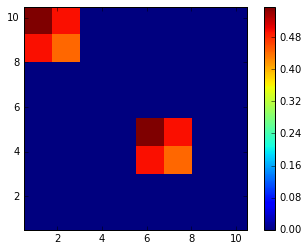

In [739]:
## Check what the projection looks like
plt.imshow((V*V_flat).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()

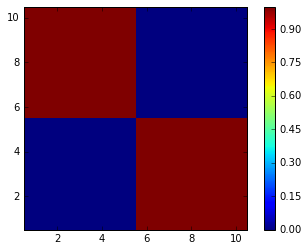

In [740]:
plt.imshow((V_flat*V).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()

In [741]:
## Construct factors for real roots.

F1 = lambda z: (numpy.matrix([[(z + significant_poles[1])/(z-significant_poles[0]), 0],
                            [0, (z + significant_poles[0])/(z-significant_poles[1])]])
               )

T_factorized_1 = lambda z: numpy.matrix(numpy.eye(D.shape[0])) - V*V_flat + V*la.inv(U)*F1(z)*(U)*V_flat

B_constant = T(1e12)*la.inv(T_factorized_1(1e12))

fact1 = lambda z: (B_constant*T_factorized_1(z)).T

### Ensure the generated factor is J-unitary and doubled-up

In [742]:
# T_factorized_1(10j)*J4*T_factorized_1(10j)-J4

In [743]:
print all([[check_J_unitary(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Check the factor equals the original transfer function

In [744]:
def plot_T_and_fact(T, fact1, z):
    plt.title("Original transfer function, real part.")
    plt.imshow((T(z)).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("New factor, real part.")
    plt.imshow((fact1(z)).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("Original transfer function, imaginary part.")
    plt.imshow((T(z)).imag, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("New factor, imaginary part.")
    plt.imshow((fact1(z)).imag, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

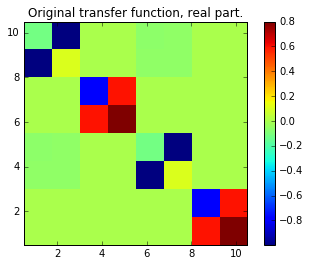

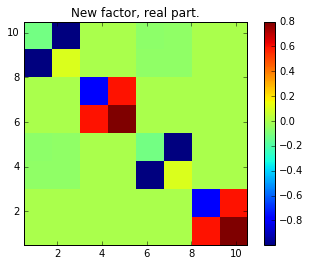

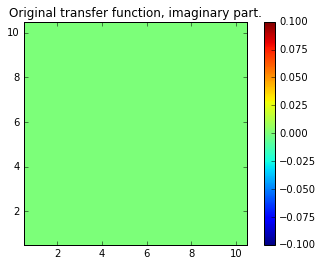

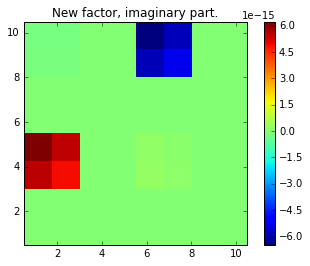

In [745]:
plot_T_and_fact(T, fact1, 0)

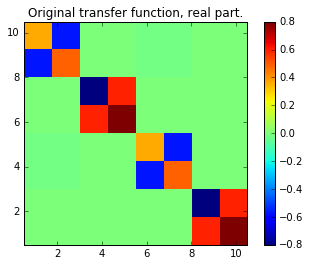

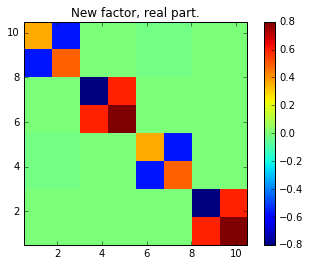

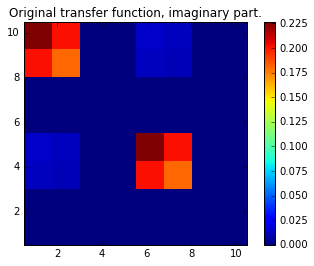

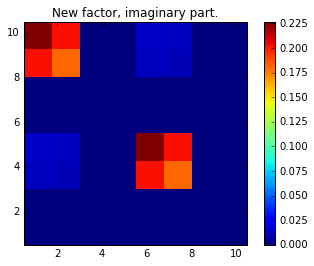

In [746]:
plot_T_and_fact(T, fact1, 1j+1.)

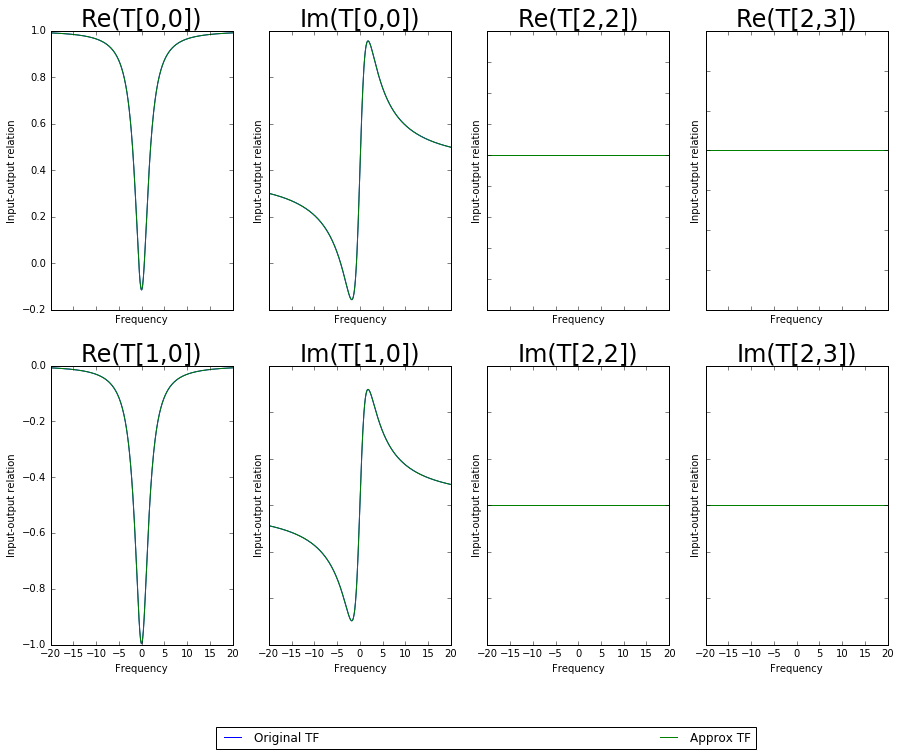

In [747]:
xr = numpy.linspace(-20,20,501)
xr_im = xr*1j
yr = numpy.array(map(T, xr_im))
zr = numpy.array(map(fact1, xr_im))

f, axarr = plt.subplots(2, 4, figsize=(15,11))

l1, = axarr[0, 0].plot(xr, yr[:,0,0].real)
l2, = axarr[0, 0].plot(xr, zr[:,0,0].real)
axarr[0, 0].set_title('Re(T[0,0])',fontsize= 24)

axarr[0, 1].plot(xr, yr[:,0,0].imag)
axarr[0, 1].plot(xr, zr[:,0,0].imag)
axarr[0, 1].set_title('Im(T[0,0])' ,fontsize= 24)

axarr[1, 0].plot(xr, yr[:,1,0].real)
axarr[1, 0].plot(xr, zr[:,1,0].real)
axarr[1, 0].set_title('Re(T[1,0])',fontsize= 24 )

axarr[1, 1].plot(xr, yr[:,1,0].imag)
axarr[1, 1].plot(xr, zr[:,1,0].imag)
axarr[1, 1].set_title('Im(T[1,0])',fontsize= 24 )

###

axarr[0,2].plot(xr, yr[:,2,2].real)
axarr[0,2].plot(xr, zr[:,2,2].real)
axarr[0,2].set_title('Re(T[2,2])',fontsize= 24 )

axarr[1,2].plot(xr, yr[:,2,2].imag)
axarr[1,2].plot(xr, zr[:,2,2].imag)
axarr[1,2].set_title('Im(T[2,2])',fontsize= 24 )

axarr[0,3].plot(xr, yr[:,2,3].real)
axarr[0,3].plot(xr, zr[:,2,3].real)
axarr[0,3].set_title('Re(T[2,3])',fontsize= 24 )

axarr[1,3].plot(xr, yr[:,2,3].imag)
axarr[1,3].plot(xr, zr[:,2,3].imag)
axarr[1,3].set_title('Im(T[2,3])',fontsize= 24 )




f.legend([l1, l2],["Original TF", "Approx TF"],
           bbox_to_anchor=(0.2, 0.001, 0.5, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)


for ax in axarr.flat:
    ax.set(xlabel='Frequency', ylabel='Input-output relation', )
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    

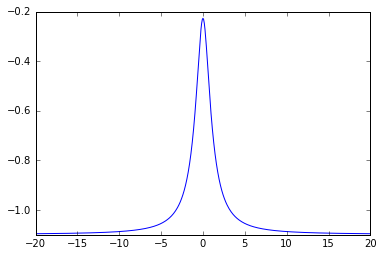

In [748]:
# Analysis of squeezing spectrum.

which_vals = zr

# r_squeeze = 0.5*numpy.log((numpy.abs(which_vals[:,0,0])+numpy.abs(which_vals[:,1,0]))
#                           /(numpy.abs(which_vals[:,0,0])-numpy.abs(which_vals[:,1,0])))

# plt.plot(xr, -r_squeeze)
# plt.show()

# r_squeeze_trunc = 0.5*numpy.log((numpy.abs(zr[:,0,0])+numpy.abs(zr[:,1,0]))
#                           /(numpy.abs(zr[:,0,0])-numpy.abs(zr[:,1,0])))


# plt.plot(xr, r_squeeze_trunc)
# plt.show()


N_ = which_vals[:,0,0]*which_vals[:,0,0].conj()
M_ = which_vals[:,0,0]*numpy.flip(which_vals[:,0,1], axis=0)

theta = 0#numpy.pi / 2

A_ = numpy.exp(2j*theta)* M_ + numpy.exp(-2j*theta)* numpy.flip(M_, axis=0).conj()
B_ = N_+numpy.flip(N_, axis=0)

# Squeezing power spectrum
PP = np.log(1 + A_ + B_)
plt.plot(xr, -PP)

## Example 2. Next we close the feedback loop with a time delay and

### Feedback operation

In [749]:
def perm(N, tuples):
    P_tot = np.matrix(numpy.eye(N))
    for t in tuples:
        P = np.matrix(numpy.zeros((N,N)))
        for i in range(N):
            if i == t[0]:
                P[t[1],t[0]] = 1
            elif i == t[1]:
                P[t[0],t[1]] = 1
            else:
                P[i,i] = 1
        P_tot = P * P_tot ## New operators come from the left...
    return P_tot

In [750]:
P_in = perm(8, [(1,2), (0,1), (5,6), (4,5)])

In [751]:
P_out = perm(8, [(2,3), (1,2), (6,7), (5,6)])

In [752]:
P_conv = numpy.matrix(np.zeros((8,8)))
p_conv_list = [0,4,1,5,2,6,3,7]
for i in range(8):
    P_conv[i, p_conv_list[i]] = 1

In [753]:
T_old = sympy.lambdify(z, T_z_num)

In [754]:
T_o = P_conv*P_out*T_z_num*P_in*P_conv.T

In [755]:
T1 = sympy.lambdify(z, T_o[0:4,0:4])

In [756]:
T2 = sympy.lambdify(z, T_o[0:4,4:8])

In [757]:
T3 = sympy.lambdify(z, T_o[4:8,0:4])

In [758]:
T4 = sympy.lambdify(z, T_o[4:8, 4:8])

### Check some properties that should be true

In [759]:
Jv = numpy.matrix([[1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,-1]])

In [760]:
print la.norm(T1(0)*Jv*T1(0).H +T2(0)*Jv*T2(0).H - Jv) < 1e-5

True


In [761]:
print la.norm(T1(0)*Jv*T3(0).H +T2(0)*Jv*T4(0).H) < 1e-5

True


In [762]:
print la.norm(T3(0)*Jv*T3(0).H +T4(0)*Jv*T4(0).H - Jv) < 1e-5

True


In [763]:
I = numpy.matrix(numpy.eye(4))

### Feedback without time delay

In [764]:
T_tilde_0 = lambda z: T1(z) + T2(z)*la.inv(I - T4(z)) * T3(z)

In [765]:
print all([[check_J_unitary(T_tilde_0,i+1j*j + 0.01, conv="consecutive")
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_tilde_0,i+1j*j + 0.01, conv="consecutive")
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Feedback with time delay

In [766]:
t = 1

In [767]:
E = lambda z: numpy.matrix(numpy.diag(numpy.exp(2*[-t*z] + 2*[0])))

In [768]:
T_tilde = lambda z: T1(z) + T2(z) * la.inv( E(-z) - T4(z) ) * T3(z)

In [769]:
print all([[check_J_unitary(T_tilde,i+1j*j + 0.01, conv="consecutive")
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_tilde,i+1j*j + 0.01, conv="consecutive")
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Plot of input-output function

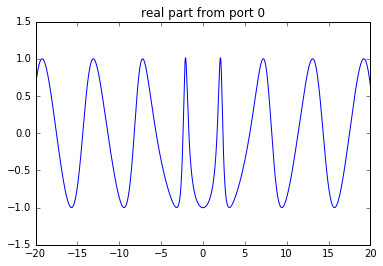

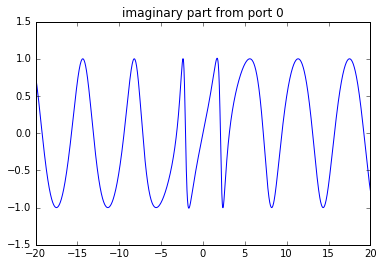

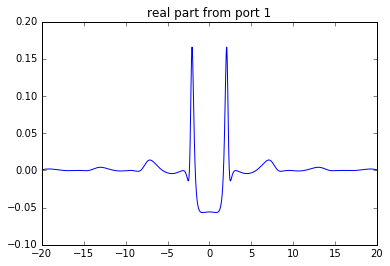

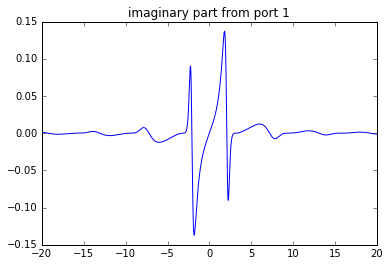

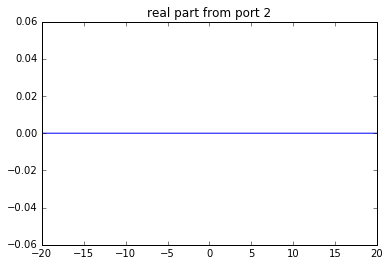

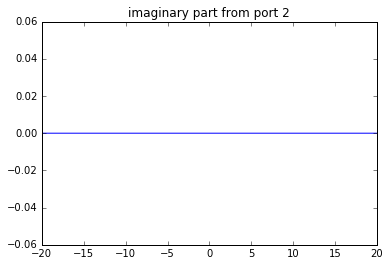

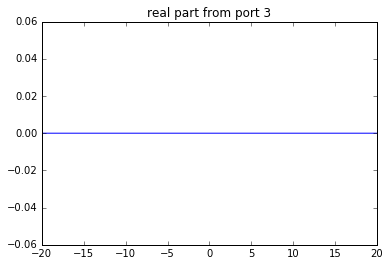

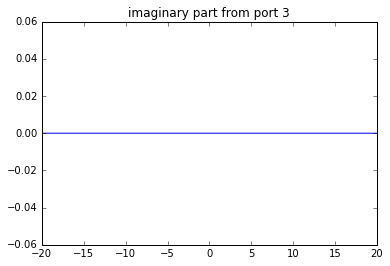

In [770]:
xr = numpy.linspace(-20,20,2000)
yr = numpy.array(map(T_tilde, xr*1j))

for i in range(yr.shape[1]):
    plt.title("real part from port %s" % str(i))
    plt.plot(xr, yr[:,i,0].real)
    plt.show()
    plt.title("imaginary part from port %s" % str(i))
    plt.plot(xr, yr[:,i,0].imag)
    plt.show()

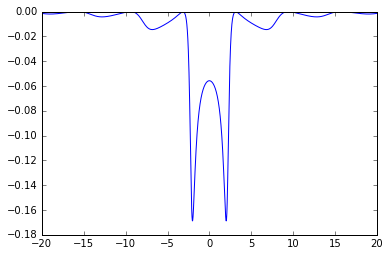

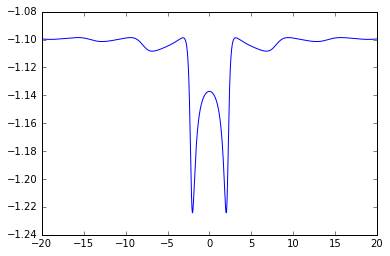

In [771]:
# Analysis of squeezing spectrum.

r_squeeze = 0.5*numpy.log((numpy.abs(yr[:,0,0])+numpy.abs(yr[:,1,0]))
                          /(numpy.abs(yr[:,0,0])-numpy.abs(yr[:,1,0])))

plt.plot(xr, -r_squeeze)
plt.show()


# r_squeeze_trunc = 0.5*numpy.log((numpy.abs(zr[:,0,0])+numpy.abs(zr[:,1,0]))
#                           /(numpy.abs(zr[:,0,0])-numpy.abs(zr[:,1,0])))


# plt.plot(xr, r_squeeze_trunc)
# plt.show()

which_vals = yr

N_ = which_vals[:,0,0]*which_vals[:,0,0].conj()
M_ = which_vals[:,0,0]*numpy.flip(which_vals[:,0,1], axis=0)

theta = 0#numpy.pi / 2

A_ = numpy.exp(2j*theta)* M_ + numpy.exp(-2j*theta)* numpy.flip(M_, axis=0).conj()
B_ = N_+numpy.flip(N_, axis=0)

# Squeezing power spectrum
PP = np.log(1 + A_ + B_)
plt.plot(xr, -PP)

## Next, find the roots for $\tilde T(z)$.

In [772]:
# reload (Roots)

T_tilde_det = lambda z: 1./la.det(T_tilde(z))
# T_tilde_det_der = lambda z: der(T_tilde_det,z, eps=1e-15)


# poles_tilde = Roots.get_roots_rect(T_tilde_det, T_tilde_det_der, 0.,0.,5.,5., 
#                                   N=1000, outlier_coeff=10.,
#                                   max_steps=1,known_roots=[],verbose=False)

# # significant_poles_tilde = Roots.purge(poles_tilde, eps = 1e-5)
# # significant_poles_tilde
# poles_tilde

### The method above didn't work well, so we use grid + Muller search.

In [962]:
poles_tilde_not_purged = []

for i in numpy.linspace(-3.,.,10):
    for j in numpy.linspace(-1,1,100):
        x1,x2,x3 = i+j*1j-0.101, i+j*1j+0.101, i+j*1j+0.001
        p = Roots.Muller(x1,x2,x3,T_tilde_det)
        poles_tilde_not_purged.append(p)

In [963]:
poles_tilde = numpy.asarray(purge(Roots.inside_boundary(poles_tilde_not_purged, 0., 0., 25., 25.), 0.05))

In [964]:
poles_tilde

array([-0.39226238 -2.17664844j, -0.34610638 -2.13572848j,
       -1.48195729 -7.88440819j, -2.41554620-20.40052624j,
       -2.07671437-14.14020843j, -2.07671437+14.14020843j,
       -2.41554620+20.40052624j, -1.48861341 +7.90597205j,
       -0.34613976 +2.13576953j, -0.39218185 +2.17662467j])

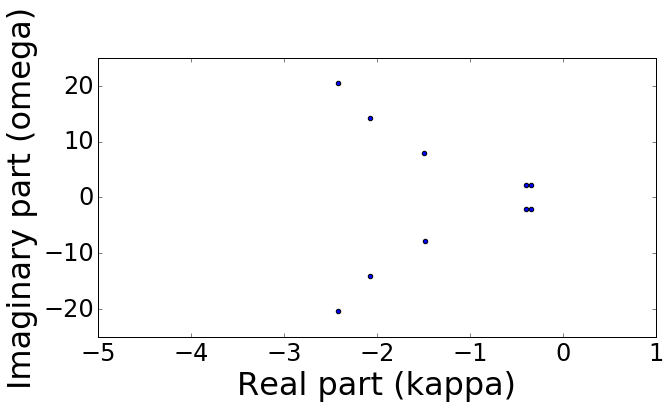

In [966]:
plt.figure(figsize=(10,5))
plt.scatter(poles_tilde.real,poles_tilde.imag, )
# plt.title("Poles", fontsize=18)
plt.xlim(-5,1)
plt.ylim(-25,25)
plt.xlabel("Real part (kappa)", fontsize=32)
plt.ylabel("Imaginary part (omega)", fontsize=32)

### Organize the poles into different categories

In [938]:
real_cutoff = 1e-3

In [939]:
complex_poles = [p for p in poles_tilde if abs(p.imag) >= real_cutoff]

In [940]:
real_poles = [p.real for p in poles_tilde if abs(p.imag) < real_cutoff]

In [941]:
pos_complex_poles = [p for p in complex_poles if p.imag > real_cutoff]

In [942]:
neg_complex_poles =  [p for p in complex_poles if p.imag < -real_cutoff]

In [943]:
pos_complex_poles

[(-2.4519246105912744+20.388397286666684j),
 (-2.0733850074981386+14.124683748715968j),
 (-1.486134038793407+7.9041803679848055j),
 (-0.34615972283525653+2.1358661256216585j),
 (-0.39218136335513143+2.1766275419279117j),
 (-2.4046449895666475+20.405590042990344j)]

In [944]:
real_poles

### Factorize the (degenerate) complex poles

In [945]:
reload(utils)

from utils import(
    double_up,
    J,
    flat,
    make_ABCD,
    make_T,
    scale_vector_doubled_up,
    real_scaling,
    make_Sigma,
    check_J_unitary,
    check_doubled_up_func,
    check_doubled_up_mat,
    purge,
    complex_prod_deg,
    factorize_complex_poles,
    factorize_real_poles,
    factorize_deg_real_pole)

In [946]:
which_poles = pos_complex_poles

In [947]:
conv = "consecutive"

In [948]:
## Print the unperturbed vectors. They are degenerate when v.H*J*v = 0.
which_vecs = factorize_complex_poles(which_poles, T_tilde, verbose=True, conv=conv)

Eigenvalues: 
[  5.44213589e-13 -2.02863971e-12j  -1.52274751e-12 -1.90131665e-12j
   0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j]
eigenvectors
[[ 0.70737609 +0.00000000e+00j  0.70683476 -6.38660095e-05j
   0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j]
 [-0.70683736 +5.59522235e-05j  0.70737870 +0.00000000e+00j
   0.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j]
 [ 0.00000000 -0.00000000e+00j  0.00000000 +0.00000000e+00j
   1.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j]
 [ 0.00000000 -0.00000000e+00j  0.00000000 +0.00000000e+00j
   0.00000000 +0.00000000e+00j  1.00000000 +0.00000000e+00j]]
Unperturbed vector is: 
[[ 0.70683476 -6.38660095e-05j]
 [ 0.70737870 +0.00000000e+00j]
 [ 0.00000000 +0.00000000e+00j]
 [ 0.00000000 +0.00000000e+00j]]
Eigenvalues: 
[  7.59733956e-12 +3.44950390e-12j   3.09243206e-09 +2.43171129e-08j
   0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j]
eigenvectors
[[ 0.70710684 +0.00000000e+00j

In [949]:
which_poles

[(-2.4519246105912744+20.388397286666684j),
 (-2.0733850074981386+14.124683748715968j),
 (-1.486134038793407+7.9041803679848055j),
 (-0.34615972283525653+2.1358661256216585j),
 (-0.39218136335513143+2.1766275419279117j),
 (-2.4046449895666475+20.405590042990344j)]

In [950]:
which_vecs

[(matrix([[ 0.71183476 -6.38660095e-05j],
          [ 0.70737870 +0.00000000e+00j],
          [ 0.00000000 +0.00000000e+00j],
          [ 0.00000000 +0.00000000e+00j]]),
  (-1.5227475093835368e-12-1.9013166527682018e-12j)),
 (matrix([[-0.70310673 +7.69744868e-09j],
          [ 0.70710684 +0.00000000e+00j],
          [ 0.00000000 -0.00000000e+00j],
          [ 0.00000000 -0.00000000e+00j]]),
  (3.0924320558901009e-09+2.431711288374648e-08j)),
 (matrix([[-0.70410678 +4.91726018e-12j],
          [ 0.70710678 +0.00000000e+00j],
          [-0.00000000 +0.00000000e+00j],
          [-0.00000000 +0.00000000e+00j]]),
  (0.00078581398250568055+9.3814997689649076e-06j)),
 (matrix([[ 0.70910678 +4.54548205e-12j],
          [ 0.70710678 +0.00000000e+00j],
          [-0.00000000 +0.00000000e+00j],
          [-0.00000000 +0.00000000e+00j]]),
  (0.79268704909657295+0.015555760559171843j)),
 (matrix([[-0.70610678 -2.52087240e-11j],
          [ 0.70710678 +0.00000000e+00j],
          [ 0.00000000 -0.000

In [951]:
T_c = lambda z: complex_prod_deg(z, which_poles[::-1], which_vecs[::-1], 4, conv=conv)

In [952]:
### Check the resulting function is J-unitary and doubled-up.

In [953]:
print all([[check_J_unitary(T_c,i+1j*j, conv=conv)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_c,i+1j*j, conv=conv)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Generate and plot the factorized functions.

In [954]:
z0 = 0 ## Point at which we specify the new function should equal the original.
T_fact = lambda z: (T_tilde(z0) * T_c(z))

In [955]:
font = {'size' : 24}

matplotlib.rc('font', **font)

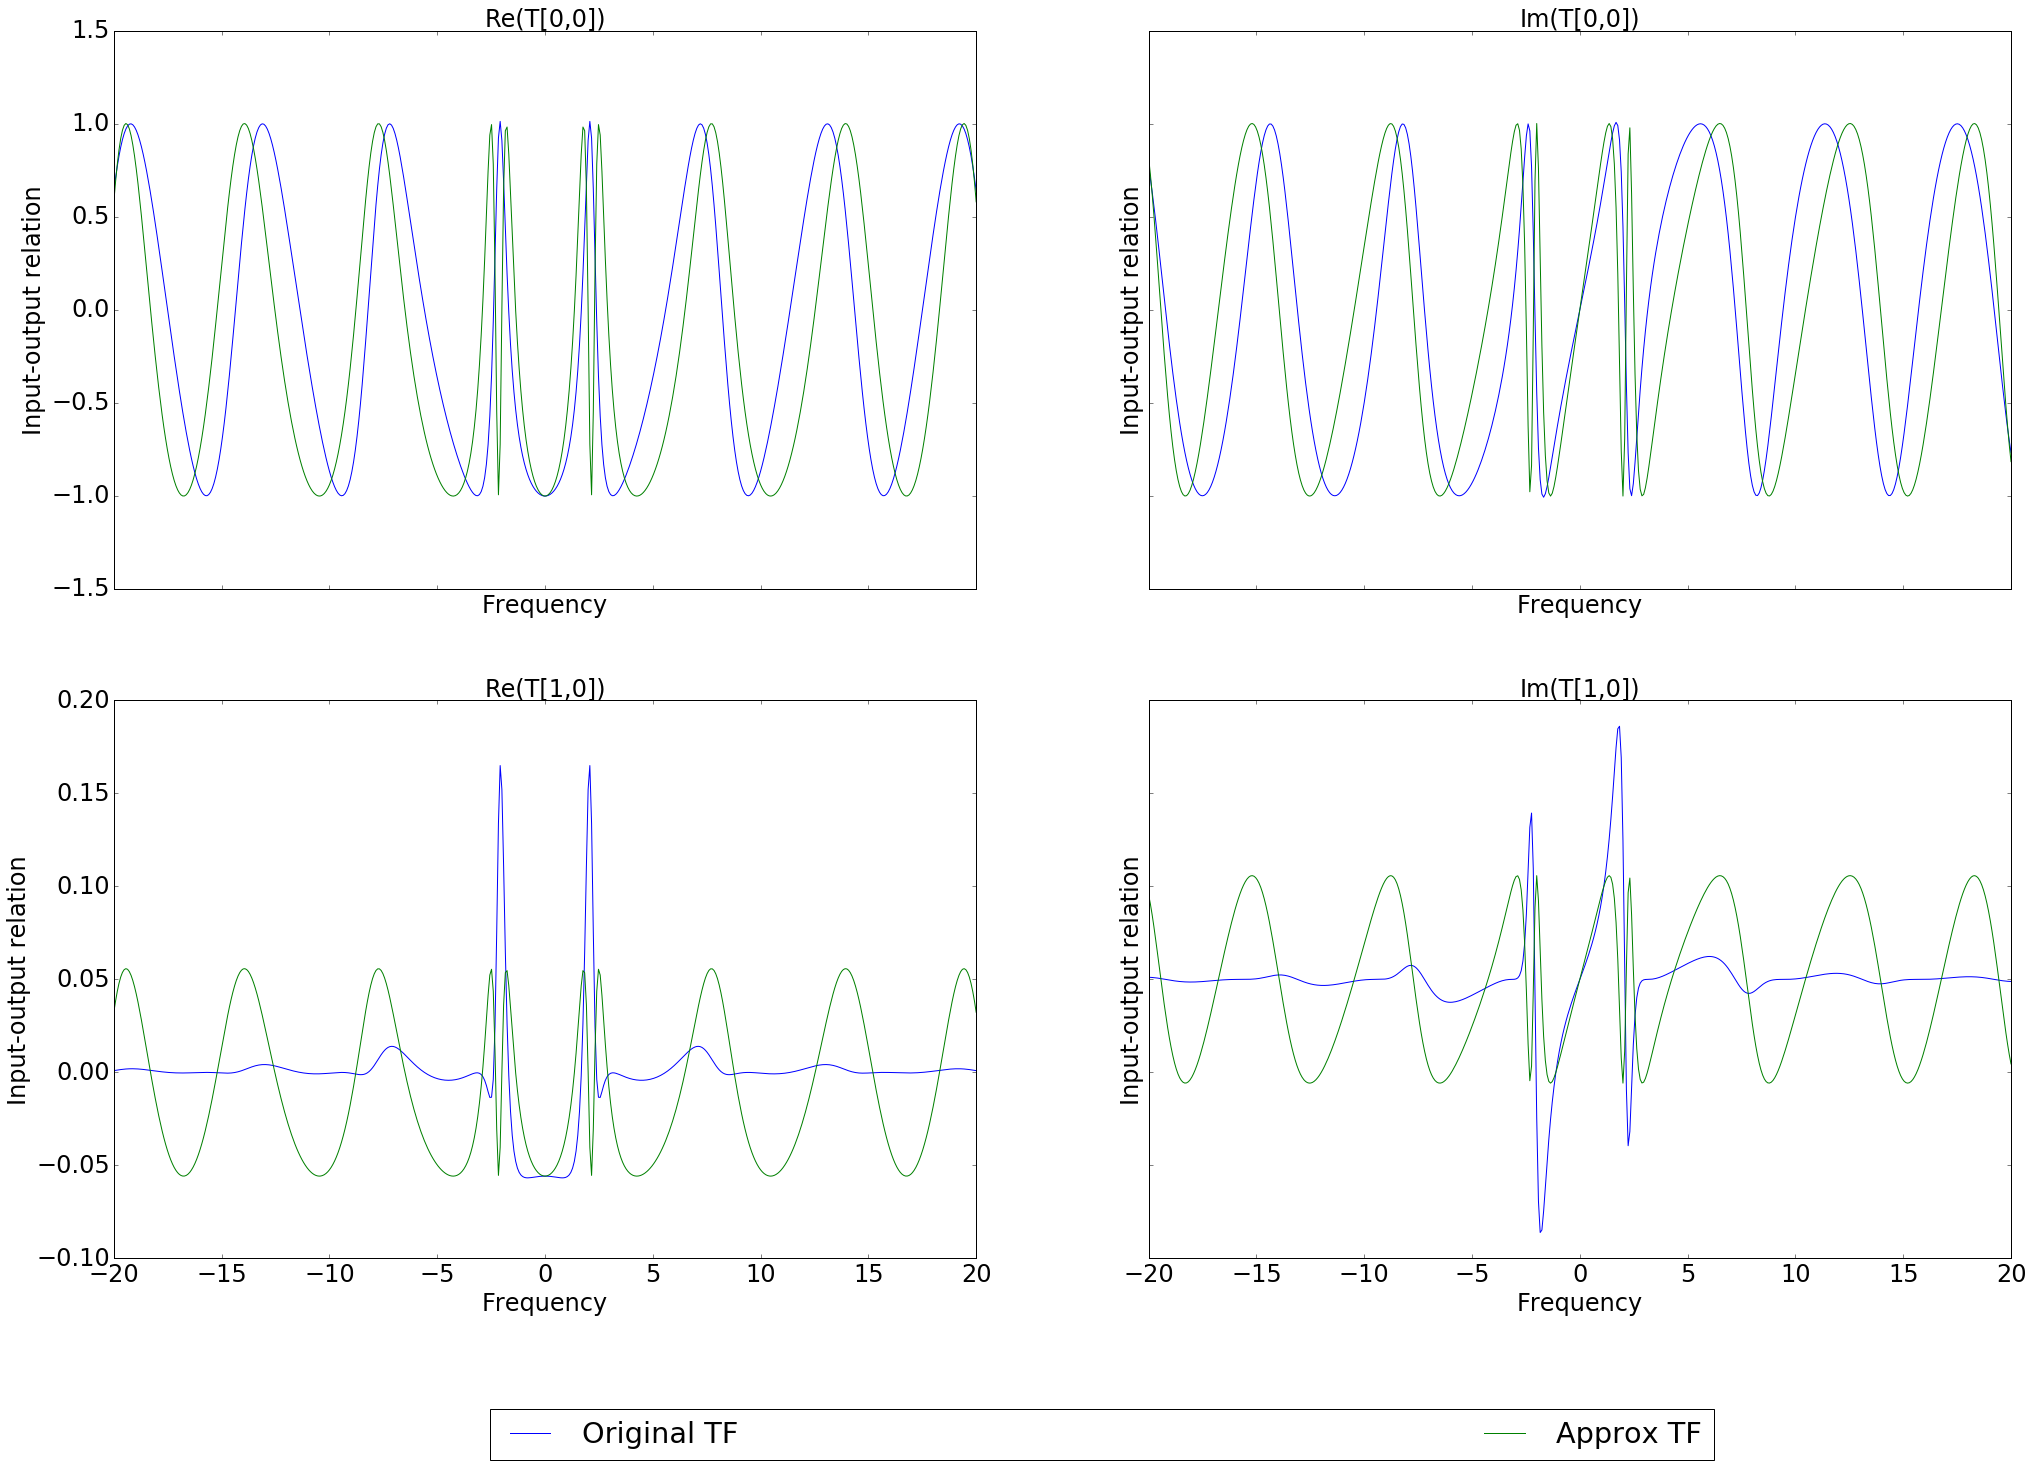

In [956]:

xr = numpy.linspace(-20,20,501)
xr_im = xr*1j
yr = numpy.array(map(T_tilde, xr_im))
zr = numpy.array(map(T_fact, xr_im))

f, axarr = plt.subplots(2, 2, figsize=(34,22))

l1, = axarr[0, 0].plot(xr, yr[:,0,0].real)
l2, = axarr[0, 0].plot(xr, zr[:,0,0].real)
axarr[0, 0].set_title('Re(T[0,0])',fontsize= 24)

axarr[0, 1].plot(xr, yr[:,0,0].imag)
axarr[0, 1].plot(xr, zr[:,0,0].imag)
axarr[0, 1].set_title('Im(T[0,0])' ,fontsize= 24)

axarr[1, 0].plot(xr, yr[:,1,0].real)
axarr[1, 0].plot(xr, zr[:,1,0].real)
axarr[1, 0].set_title('Re(T[1,0])',fontsize= 24 )

axarr[1, 1].plot(xr, yr[:,1,0].imag)
axarr[1, 1].plot(xr, zr[:,1,0].imag)
axarr[1, 1].set_title('Im(T[1,0])',fontsize= 24 )


f.legend([l1, l2],["Original TF", "Approx TF"],
           bbox_to_anchor=(0.2, 0.001, 0.5, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)


for ax in axarr.flat:
    ax.set(xlabel='Frequency', ylabel='Input-output relation', )
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    

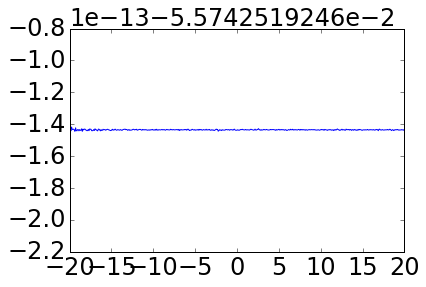

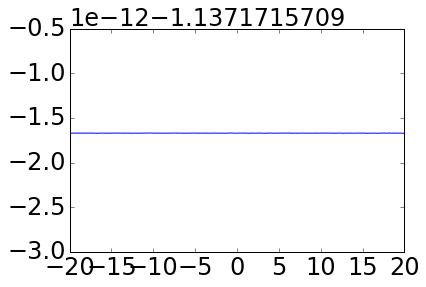

In [957]:
# Analysis of squeezing spectrum.

which_vals = zr

r_squeeze = 0.5*numpy.log((numpy.abs(which_vals[:,0,0])+numpy.abs(which_vals[:,1,0]))
                          /(numpy.abs(which_vals[:,0,0])-numpy.abs(which_vals[:,1,0])))

plt.plot(xr, -r_squeeze)
plt.show()

# r_squeeze_trunc = 0.5*numpy.log((numpy.abs(zr[:,0,0])+numpy.abs(zr[:,1,0]))
#                           /(numpy.abs(zr[:,0,0])-numpy.abs(zr[:,1,0])))


# plt.plot(xr, r_squeeze_trunc)
# plt.show()


N_ = which_vals[:,0,0]*which_vals[:,0,0].conj()
M_ = which_vals[:,0,0]*numpy.flip(which_vals[:,0,1], axis=0)

theta = 0#numpy.pi / 2

A_ = numpy.exp(2j*theta)* M_ + numpy.exp(-2j*theta)* numpy.flip(M_, axis=0).conj()
B_ = N_+numpy.flip(N_, axis=0)

# Squeezing power spectrum
PP = np.log(1 + A_ + B_)
plt.plot(xr, -PP)